In [1]:
# Basic scientific python imports
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline
# Spikeinterface imports (could do this cleaner, oh well)
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.preprocessing as spre
import spikeinterface.exporters as sxp
import spikeinterface.widgets as sw
import spikeinterface.full as si
import probeinterface as pi
from probeinterface.plotting import plot_probe
import spikeinterface.curation as scur
import mountainsort5 as ms5

# Core python imports
import os
import time
from pathlib import Path
from IPython.display import Audio

C:\Users\lwood39\.conda\envs\autospikesort\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## If reading series of intan recordings
# path_to_folder = os.path.normpath(r'C:\Users\lwood39\Documents\VNCMP\2024-06-03_13-52-03')
# dircontents = os.listdir(path_to_folder)
# file_names = [x for x in dircontents if '.rhd' in x]
# recording_list = []
# for file in file_names:
#     path_to_file = os.path.join(path_to_folder, file)
#     recording_list.append(se.IntanRecordingExtractor(path_to_file, stream_id='0'))
# recording = si.concatenate_recordings(recording_list)
# display(recording)

# rec_name = 'C:/Users/lwood39/Documents/VNCMP/2023-05-25-01/poke2_230525_160704'
# recording = se.IntanRecordingExtractor(rec_name, stream_id='0')
# recording = recording.frame_slice(start_frame=0, end_frame=int(231*30000))

## If reading open ephys recording session
path_to_folder = Path('C:/Users/lwood39/Documents/VNCMP/2024-06-03_13-52-03/Record Node 103/')
recording = se.read_openephys(path_to_folder, block_index=0, stream_id='0')
recording = si.SelectSegmentRecording(recording, 0)

In [3]:
# Remove analog input channels if present, not needed for spike sorting
if any('ADC' in s for s in recording.get_channel_ids()):  
    recording = recording.remove_channels([x for x in recording.get_channel_ids() if 'ADC' in x])
recording.get_channel_ids()

array(['CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6', 'CH7', 'CH8', 'CH9',
       'CH10', 'CH11', 'CH12', 'CH13', 'CH14', 'CH15', 'CH16', 'CH17',
       'CH18', 'CH19', 'CH20', 'CH21', 'CH22', 'CH23', 'CH24', 'CH25',
       'CH26', 'CH27', 'CH28', 'CH29', 'CH30', 'CH31', 'CH32'],
      dtype='<U64')

(<matplotlib.collections.PolyCollection at 0x229f115e210>,
 <matplotlib.collections.PolyCollection at 0x229f1125410>)

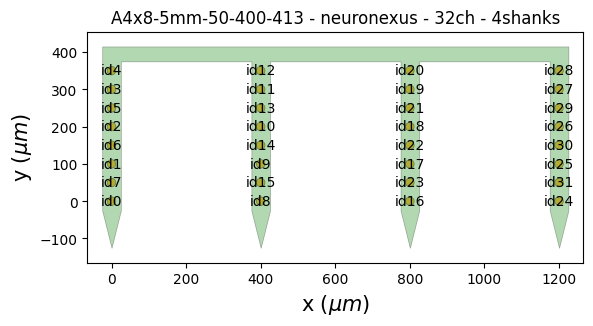

In [4]:
probe = pi.read_probeinterface('A4x8-5mm-50-400-413_A32.json')
recording.set_probegroup(probe)
recording.set_probe(probe.probes[0], in_place=True)
plot_probe(probe.probes[0], with_contact_id=True, with_device_index=False)
# plot_probe(probe, with_contact_id=True, with_device_index=True)

### Run filter, zscore data, then save cache

NOTE: If using mountainsort5, filter then zscore with mean+std recommended.
We found whitening often not reliable, but mountainsort5 expects unit variance so zscoring is essential

In [5]:
recording_filter = spre.bandpass_filter(recording, freq_min=300, freq_max=5000)
recording_zscore = spre.zscore(recording_filter, mode='mean+std')
# recording_cache_preprocessed = recording_zscore.save(format='binary', n_jobs=8, chunk_duration='10s')

## Run Sorter

In [6]:
si.available_sorters()

['combinato',
 'hdsort',
 'herdingspikes',
 'ironclust',
 'kilosort',
 'kilosort2',
 'kilosort2_5',
 'kilosort3',
 'kilosort4',
 'klusta',
 'mountainsort4',
 'mountainsort5',
 'pykilosort',
 'simple',
 'spykingcircus',
 'spykingcircus2',
 'tridesclous',
 'tridesclous2',
 'waveclus',
 'waveclus_snippets',
 'yass']

In [7]:
sorter = 'mountainsort5'
print(ss.get_default_sorter_params(sorter))
ss.get_sorter_params_description(sorter)

{'scheme': '2', 'detect_threshold': 5.5, 'detect_sign': -1, 'detect_time_radius_msec': 0.5, 'snippet_T1': 20, 'snippet_T2': 20, 'npca_per_channel': 3, 'npca_per_subdivision': 10, 'snippet_mask_radius': 250, 'scheme1_detect_channel_radius': 150, 'scheme2_phase1_detect_channel_radius': 200, 'scheme2_detect_channel_radius': 50, 'scheme2_max_num_snippets_per_training_batch': 200, 'scheme2_training_duration_sec': 300, 'scheme2_training_recording_sampling_mode': 'uniform', 'scheme3_block_duration_sec': 1800, 'freq_min': 300, 'freq_max': 6000, 'filter': True, 'whiten': True, 'delete_temporary_recording': True, 'n_jobs': 1, 'chunk_duration': '1s', 'progress_bar': True, 'mp_context': None, 'max_threads_per_process': 1}


{'scheme': "Which sorting scheme to use: '1, '2', or '3'",
 'detect_threshold': 'Detection threshold - recommend to use the default',
 'detect_sign': 'Use -1 for detecting negative peaks, 1 for positive, 0 for both',
 'detect_time_radius_msec': 'Determines the minimum allowable time interval between detected spikes in the same spatial region',
 'snippet_T1': 'Number of samples before the peak to include in the snippet',
 'snippet_T2': 'Number of samples after the peak to include in the snippet',
 'npca_per_channel': 'Number of PCA features per channel in the initial dimension reduction step',
 'npca_per_subdivision': 'Number of PCA features to compute at each stage of clustering in the isosplit6 subdivision method',
 'snippet_mask_radius': 'Radius of the mask to apply to the extracted snippets',
 'scheme1_detect_channel_radius': 'Channel radius for excluding events that are too close in time in scheme 1',
 'scheme2_phase1_detect_channel_radius': 'Channel radius for excluding events tha

In [8]:
timer = time.time()
# ms5_params = ms5.Scheme3SortingParameters(
#     block_sorting_parameters=ms5.Scheme2SortingParameters()
#     block_duration_sec=200
# )
ms5_params = ms5.Scheme2SortingParameters(
    detect_sign=1,
    phase1_detect_threshold=3.0,
    detect_threshold=3.0,
    phase1_detect_time_radius_msec=0.7,
    phase1_detect_channel_radius=50,
    detect_time_radius_msec=0.5,
    detect_channel_radius=50,
    phase1_npca_per_channel=3,
    phase1_npca_per_subdivision=25,
    classifier_npca=None,
    snippet_T1=20,
    snippet_T2=20,
    snippet_mask_radius=70,
    training_duration_sec=int(0.6 * recording.get_duration()),
    max_num_snippets_per_training_batch=20000)
sort = ms5.sorting_scheme2(
    recording=recording_zscore,
    sorting_parameters=ms5_params
)
assert isinstance(sort, si.BaseSorting)
elapsed_sec = time.time() - timer
duration_sec = recording.get_total_duration()
print(sort)
print(f'Elapsed time for sorting: {elapsed_sec:.2f} sec') 
print(f'x{(duration_sec / elapsed_sec):.2f} speed compared with real time for {recording.get_num_channels()} channels')

# Sorting object comes out as NumpySorting, which sits in RAM. Have to move to disk to export to phy
sort_file_path = './most_recent_sort.npz'
se.NpzSortingExtractor.write_sorting(sort, sort_file_path)
time.sleep(1)
Audio('notification-sound.wav', autoplay=True)

Using training recording of duration 81 sec with the sampling mode initial
*** MS5 Elapsed time for SCHEME2 get_sampled_recording_for_training: 3.354 seconds ***
Running phase 1 sorting
Number of channels: 32
Number of timepoints: 2430000
Sampling frequency: 30000.0 Hz
Channel 0: [800.   0.]
Channel 1: [800.  50.]
Channel 2: [800. 200.]
Channel 3: [1200.   50.]
Channel 4: [1200.  150.]
Channel 5: [1200.  350.]
Channel 6: [1200.    0.]
Channel 7: [800. 150.]
Channel 8: [800. 350.]
Channel 9: [800. 250.]
Channel 10: [1200.  200.]
Channel 11: [1200.  300.]
Channel 12: [1200.  250.]
Channel 13: [800. 300.]
Channel 14: [1200.  100.]
Channel 15: [800. 100.]
Channel 16: [400.  50.]
Channel 17: [  0. 300.]
Channel 18: [400. 250.]
Channel 19: [400. 200.]
Channel 20: [  0. 150.]
Channel 21: [  0. 200.]
Channel 22: [  0. 250.]
Channel 23: [400. 100.]
Channel 24: [400. 300.]
Channel 25: [ 0. 50.]
Channel 26: [  0. 100.]
Channel 27: [  0. 350.]
Channel 28: [400.   0.]
Channel 29: [400. 350.]
Channe

## Extract, save to Phy GUI

In [ ]:
job_kwargs = dict(n_jobs=8, chunk_duration="100s", progress_bar=True)
analyzer = si.create_sorting_analyzer(sorting=sort, recording=recording_zscore)
analyzer.compute(['random_spikes', 'waveforms', 'templates', 'noise_levels'])
_ = analyzer.compute('spike_amplitudes', **job_kwargs)
_ = analyzer.compute('principal_components', n_components = 5, mode="by_channel_local", **job_kwargs)

phy_save_path = os.path.join(os.path.dirname(path_to_folder), 'phy_folder',  os.path.basename(path_to_folder))
sxp.export_to_phy(sorting_analyzer=analyzer, 
                  output_folder=phy_save_path, 
                  remove_if_exists=True,
                  **job_kwargs)

with open(phy_save_path + '/params_log.txt', 'w') as f:
    for key, value in ms5_params.__dict__.items():
        if key == 'block_sorting_parameters':
            for subkey, subvalue in value.__dict__.items():
                f.write('%s:%s\n' % (subkey, subvalue))
        else:
            f.write('%s:%s\n' % (key, value))

time.sleep(1)
Audio('notification-sound.wav', autoplay=True)

C:\Users\lwood39\.conda\envs\autospikesort\Lib\site-packages\spikeinterface\core\job_tools.py:103: UserWarning: `n_jobs` is not set so parallel processing is disabled! To speed up computations, it is recommended to set n_jobs either globally (with the `spikeinterface.set_global_job_kwargs()` function) or locally (with the `n_jobs` argument). Use `spikeinterface.set_global_job_kwargs?` for more information about job_kwargs.
  warnings.warn(
Fitting PCA:  21%|██        | 8/38 [01:31<05:45, 11.53s/it]

 To run Phy, use cmd or Powershell, and do one of the following:
 
 1. Run the command spit out by the cell above, often something like:
 
 ```phy template-gui  C:\Users\lwood39\Documents\AutoSpikeSort\phy_folder\mountainsort5_poke1_230520_153135\params.py```
 
 
 2. Navigate to phy_folder created by the above cell, then run phy command
 
 Example:
 
 ```cd C:/Users/lwood39/Documents/AutoSpikeSort/phy_folder_kilosort```
 
 ```phy template-gui params.py```
 

## Plot sandbox

<IPython.core.display.Javascript object>


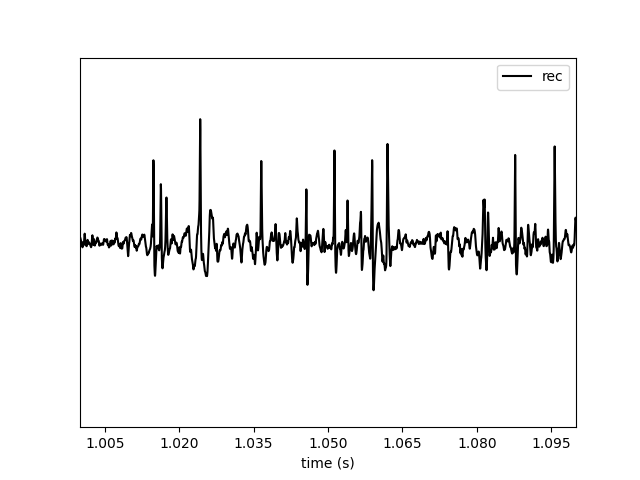

<IPython.core.display.Javascript object>


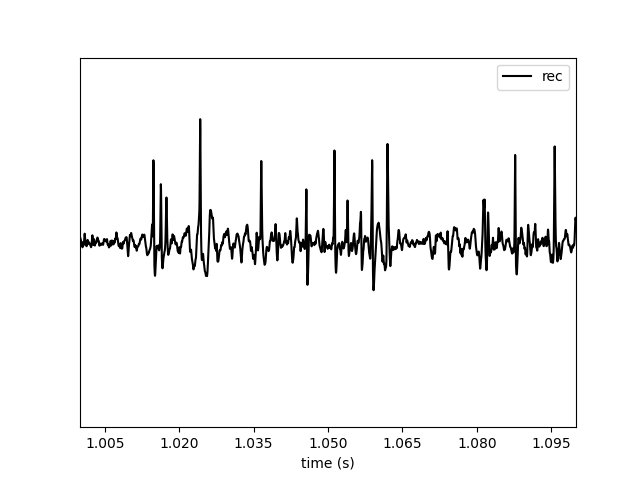

In [69]:
sw.plot_timeseries(recording_cache_filter, time_range=(1, 1.1), channel_ids=['0'], return_scaled=True)
sw.plot_timeseries(recording_cache_preprocessed, time_range=(1, 1.1), channel_ids=['0'], return_scaled=True)
plt.show()

<IPython.core.display.Javascript object>


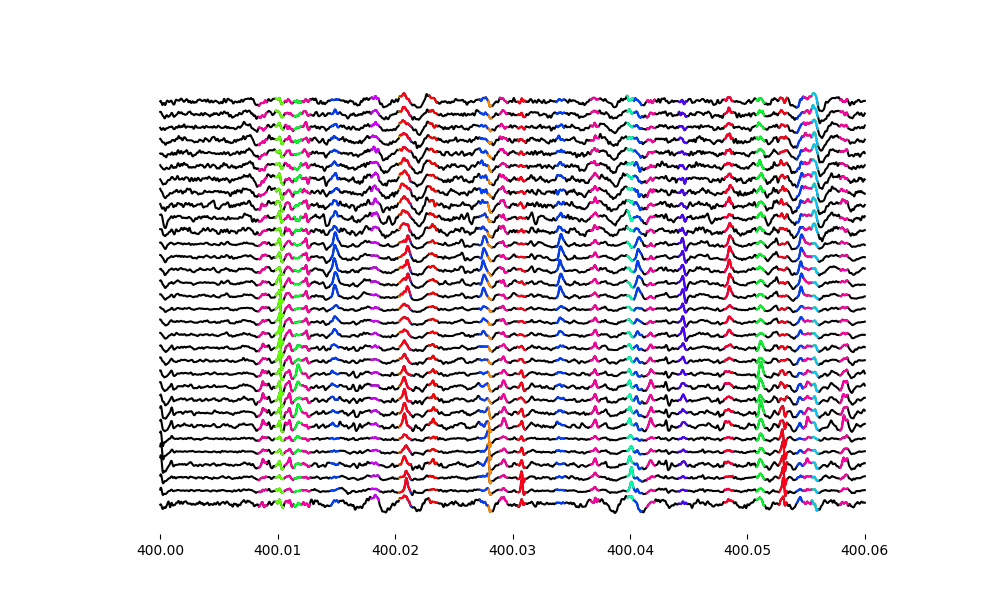

In [95]:
from matplotlib import cm

cmap = cm.get_cmap('hsv', 12)
# colors = cmap(np.linspace(0, 1, len(wave_extract.sorting.get_unit_ids())))

startframe, endframe = 400, 400.06
frame_range = [int(startframe*30000), int(endframe*30000)]
data = recording_cache_preprocessed.get_traces(start_frame=int(startframe*30000), end_frame=int(endframe*30000), 
    return_scaled=True, channel_ids=[str(i) for i in range(32)])
x = np.linspace(startframe, endframe, data.shape[0])

# plt.style.use("dark_background")
plt.figure(figsize=(10, 6))
ax = plt.gca()
channel_plot_order = [
    18, 29, 13, 30, 2, 3, 25, 6, 21, 31, 12, 28, 1, 17, 15, 5, 23, 7, 27, 16, 11, 19, 9, 22, 0, 10, 24, 8, 20, 14, 26, 4
]
for i,ch in enumerate(channel_plot_order):
    ydat = data[:,ch] / (np.max(data[:,ch]) - np.min(data[:,ch])) * 1.4
    plt.plot(x, ydat + i, 'k')
inc = 0
for unit in wave_extract.sorting.get_unit_ids():
    spike_frames = wave_extract.sorting.get_unit_spike_train(unit)
    spike_start, spike_end = np.searchsorted(spike_frames, frame_range)
    spike_frames_to_plot = spike_frames[spike_start:spike_end] - frame_range[0]
    for spike in spike_frames_to_plot:
        ind_end = spike + 10 if spike + 10 < (frame_range[1] - frame_range[0]) else frame_range[1] - frame_range[0]
        inds = np.arange(spike - 10, ind_end)
        for i,ch in enumerate(channel_plot_order):
            ydat = data[inds,ch] / (np.max(data[:,ch]) - np.min(data[:,ch])) * 1.4
            plt.plot(x[inds], ydat + i, color=cmap(inc))
    if len(spike_frames_to_plot) >= 1:
        inc += 1
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.get_yaxis().set_ticks([])
plt.show()

In [9]:
we = si.load_waveforms('C:/Users/lwood39/Documents/AutoSpikeSort/waveforms')

<IPython.core.display.Javascript object>


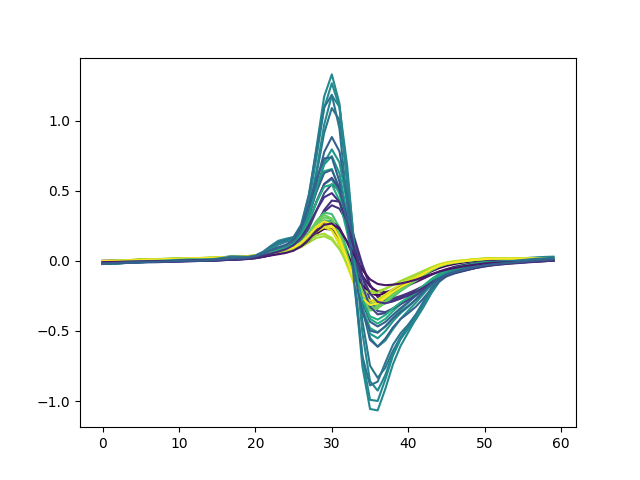

In [8]:
from matplotlib import cm

cmap = cm.get_cmap('viridis', 50)

wave = np.mean(we.get_waveforms(6), axis=0)
locations = we.get_channel_locations()
locmin, locmax = np.min(locations[:,1]), np.max(locations[:,1])
plt.figure()
for i in range(32):
    plt.plot(wave[:,i], color=cmap(np.abs(locations[i,1] - locmin) / (locmax-locmin)))
plt.show()

In [43]:
60 - np.argmax(np.correlate(wave[:,1], wave[:,2], mode='full'))

2

<IPython.core.display.Javascript object>


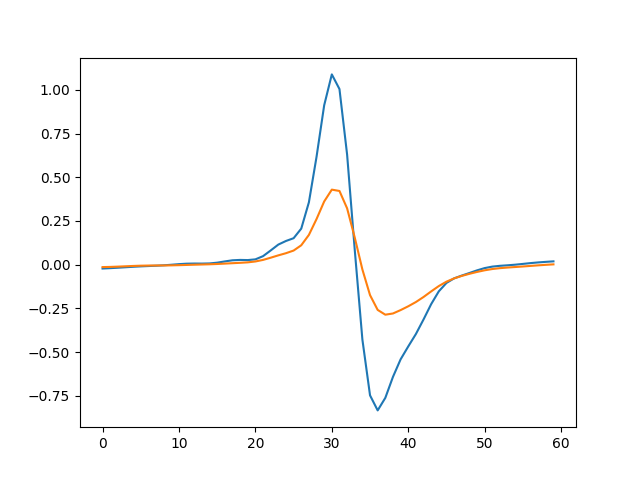

In [42]:
plt.figure()
# plt.plot(np.correlate(wave[:,1], wave[:,1], mode='full'))
# plt.xcorr(wave[:,2], wave[:,1])
plt.plot(wave[:,1])
plt.plot(wave[:,2])
plt.show()

In [51]:
np.mean(we.get_waveforms(1), axis=0).shape

(60, 32)

In [99]:
import itertools

velocities = {}
delays = {}
pair_vectors = {}
mean_vectors = []
locations = we.get_channel_locations()
unit = we.sorting.get_unit_ids()[0]
# for unit in we.sorting.get_unit_ids():
# Loop over each combination of channels
for pair in itertools.combinations(range(32),2):
    waves = we.get_waveforms(unit)
    delay = np.empty(waves.shape[0])
    delay[:] = np.nan
#         vectors = np.zeros((waves.shape[0], 2))
    for i in range(waves.shape[0]):  
        wave1, wave2 = waves[i,pair[0]], waves[i,pair[1]]
        delay[i] = (wave1.shape[0] - np.argmax(np.correlate(wave1, wave2, mode='full'))) / 30000
    mask = np.logical_and(~np.isnan(delay), delay != 0)
#     unitvec = (locations[pair[1]] - locations[pair[0]]) / np.linalg.norm(locations[pair[1]] - locations[pair[0]])
    vectors = np.tile(locations[pair[1]] - locations[pair[0]], (np.sum(mask), 1)) / delay[mask, None]
    delays[pair] = delay[mask]
    pair_vectors[pair] = vectors
    mean_vectors.append(np.mean(vectors, axis=0))
    # Positive if wave1 is behind/delayed from wave2
#     dist = np.linalg.norm(locations[pair[1]] - locations[pair[0]])
#     unitvec = (locations[pair[1]] - locations[pair[0]]) / dist

#     velocities[unit] = np.sum(np.array(vectors), axis=0) / 1000

In [114]:
np.mean(np.linalg.norm(np.array(mean_vectors) / 30000 , axis=1))

0.0012600452598553464

In [116]:
delays

{(0, 1): array([1., 1., 1., ..., 1., 1., 1.]),
 (0, 2): array([1., 1., 1., ..., 1., 1., 1.]),
 (0, 3): array([1., 1., 1., ..., 1., 1., 1.]),
 (0, 4): array([1., 1., 1., ..., 1., 1., 1.]),
 (0, 5): array([ 1.,  1.,  1., ...,  1., 20.,  1.]),
 (0, 6): array([ 1.,  1.,  1., ..., -1., 15.,  1.]),
 (0, 7): array([ 1.,  1.,  2., ..., -1., 15.,  1.]),
 (0, 8): array([ 1.,  1.,  2., ...,  1., 15.,  1.]),
 (0, 9): array([1., 1., 2., ..., 1., 9., 1.]),
 (0, 10): array([ 1.,  1.,  2., ..., -1.,  9.,  1.]),
 (0, 11): array([ 1.,  1.,  2., ..., -1., -7.,  1.]),
 (0, 12): array([ 1.,  1.,  2., ..., -1., -7.,  5.]),
 (0, 13): array([ 1.,  1.,  2., ..., -5., -3.,  1.]),
 (0, 14): array([ 1.,  1.,  2., ..., -5., -3.,  1.]),
 (0, 15): array([ 32.,   1., -17., ...,  -7.,  -3.,   1.]),
 (0, 16): array([ 32.,   1., -17., ...,  -7.,  -3.,   1.]),
 (0, 17): array([-30.,   1., -30., ..., -30.,  -3.,   1.]),
 (0, 18): array([-30.,   1., -30., ..., -30.,   1.,   1.]),
 (0, 19): array([-30., -13., -30., ..., -30

<IPython.core.display.Javascript object>


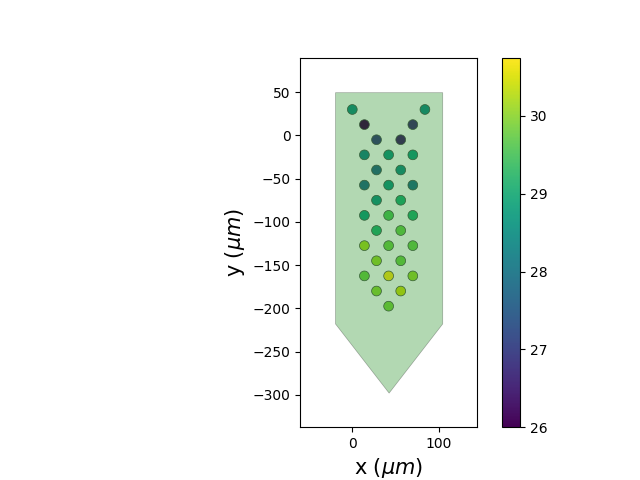

In [165]:
leads = np.argmax(wave_extract.get_waveforms(8), axis=1)
values = np.mean(leads, axis=0)
# lead_values = np.argmax(wave, axis=0)
fig, ax = plt.subplots()
poly, poly_contour = pi.plotting.plot_probe(wave_extract.recording.get_probe(), contacts_values=values,
            cmap='viridis', ax=ax, contacts_kargs={'alpha' : 1},  title=False)
# poly.set_clim(-2, 2)
fig.colorbar(poly)

<IPython.core.display.Javascript object>


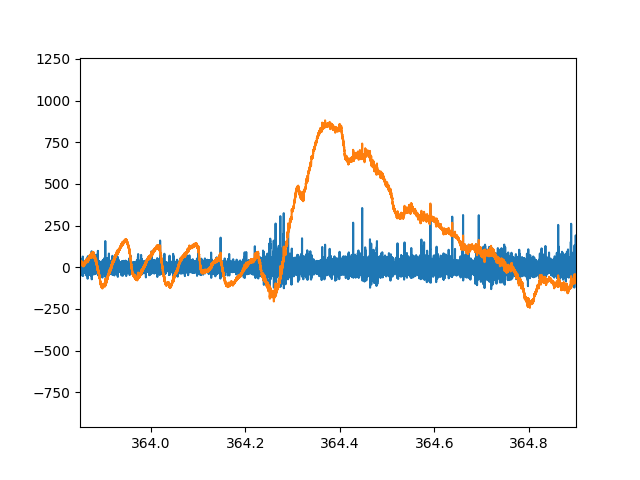

In [56]:
times = (300, 400)
data = recording_cache_justfilter.get_traces(start_frame=int(times[0]*fs), 
                                      end_frame=int(times[1]*fs), 
                                      return_scaled=True, 
                                      channel_ids=['3'])
rawdata = recording_cache_raw.get_traces(start_frame=int(times[0]*fs), 
                                      end_frame=int(times[1]*fs), 
                                      return_scaled=True, 
                                      channel_ids=['3'])
time = np.arange(times[0], times[1], 1/fs)
plt.figure()
plt.plot(time, data)
plt.xlim((363.85, 364.9))
# plt.show()

# plt.figure()
plt.plot(time, rawdata/5)
plt.xlim((363.85, 364.9))
plt.show()

In [84]:
1 / delay

array([1., 1., 1., ..., 1., 1., 1.])